# Loading Packages and Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# to show the whole output results
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# load data
data = pd.read_csv('../dataset/Bondora_raw.csv', low_memory=False)

In [4]:
# sort data features/columns alphabitcally (just to ease exploration)
data = data.sort_index(axis=1)

# Generate Targets

### - Loan Tenure

In [5]:
# separate year and month of MaturityDate_Original
data['MaturityDate_Original'] = pd.to_datetime(data["MaturityDate_Original"], format="%Y-%m-%d")
MaturityDate_Original_year = data['MaturityDate_Original'].dt.year
MaturityDate_Original_month = data['MaturityDate_Original'].dt.month

# separate year and month of LoanDate
data['LoanDate'] = pd.to_datetime(data["LoanDate"], format="%Y-%m-%d")
LoanDate_year = data['LoanDate'].dt.year
LoanDate_month = data['LoanDate'].dt.month

# compute Loan_Tenure
data['Loan_Tenure'] = (MaturityDate_Original_year - LoanDate_year) * 12 -( MaturityDate_Original_month - LoanDate_month)

### - EMI (Equated Monthly Installments)

In [6]:
result_1 = data["Interest"] * data["Amount"] * np.power( (1 + data["Interest"])  , data['Loan_Tenure'])
result_2 = np.power( (1 + data["Interest"])  , data['Loan_Tenure']) - 1
data["EMI"] = result_1/result_2

### - ELA (Eligible Loan Amount)

In [7]:
data["Total_Payment_Due"]  = data["AppliedAmount"] + data["Interest"] * data["AppliedAmount"] * data["Loan_Tenure"]
data["Max_allowable_amount"] = (data["IncomeTotal"] - data["LiabilitiesTotal"]) * 0.3

data["ELA"] = data.apply(lambda row: row["AppliedAmount"] if row["Total_Payment_Due"] <= row["Max_allowable_amount"] else row["Max_allowable_amount"], axis=1)
    
dropped_columns=['Total_Payment_Due','Max_allowable_amount']
data = data.drop(dropped_columns, axis=1)

### - PROI (Preferred Return on Investment)

In [8]:
data["ROI"] = data["Interest"] / data["AppliedAmount"] * 100

In [9]:
PROI = np.median(data['ROI'])

for index, row in data.iterrows():
    
    if 850 <= row['AppliedAmount'] <= 1175:
        PROI -= 5
    elif row['AppliedAmount'] >= 2000:
        PROI += 5

    if row['Loan_Tenure'] <= 19:
        PROI -= 5
    elif row['Loan_Tenure'] > 25:
        PROI += 5

    if row['IncomeTotal'] <= 1000:
        PROI -= 5

    if row['DebtToIncome'] == 0:
        PROI -= 5
    else:
        PROI += 5

In [10]:
print('PROI (Preferred Return on Investment): ',PROI)

PROI (Preferred Return on Investment):  321341.57035294117


### - Status

In [11]:
status_mapping = {
    'Repaid': 0,
    'Late': 1,
    'Current': 0
}
data['Status'] = data['Status'].map(status_mapping)

# Data PreProcessing

## - Drop some features

In [12]:
# drop feature column which has null counts with percentage more than 40%
dropped_nulls_features=[]
for column in data:
    nulls_percentage = (data[column].isnull().sum()/data.shape[0])*100
    if(nulls_percentage > 40):
        dropped_nulls_features.append(column) 
        
new_data = data.drop(dropped_nulls_features, axis=1)

In [13]:
# drop unneeded columns
dropped_features=['LoanId','LoanNumber','ReportAsOfEOD','City','County','DateOfBirth','UserName','IncomeFromChildSupport','IncomeFromFamilyAllowance','IncomeFromLeavePay','IncomeFromPension','IncomeFromPrincipalEmployer','IncomeFromSocialWelfare','IncomeOther','BiddingStartedOn','FirstPaymentDate','LastPaymentOn','ListedOnUTC','LoanApplicationStartedDate','LoanDate','MaturityDate_Last','MaturityDate_Original','StageActiveSince','ApplicationSignedHour','ApplicationSignedWeekday','MonthlyPaymentDay','ModelVersion','CreditScoreEsMicroL','WorseLateCategory','ActiveScheduleFirstPaymentReached','NextPaymentNr','PreviousEarlyRepaymentsCountBeforeLoan','RefinanceLiabilities']
new_data = new_data.drop(dropped_features, axis=1)

## - Numerical to Categorical

In [14]:
# Education
# 1 Primary education 2 Basic education 3 Vocational education 4 Secondary education 5 Higher education

new_data['Education'] = new_data['Education'].astype(str)
print(new_data['Education'].unique())

mapping = {'-1.0':'Unknown','0.0':'Unknown','1.0':'Primary education','2.0':'Basic education','3.0':'Vocational education','4.0':'Secondary education','5.0':'Higher education','nan':np.nan}
new_data['Education'] = new_data['Education'].replace(mapping)
print(new_data['Education'].unique())

new_data['Education'].fillna('Unknown',inplace=True)
print(new_data['Education'].unique())

['3.0' '5.0' '4.0' '2.0' '1.0' '0.0' 'nan' '-1.0']
['Vocational education' 'Higher education' 'Secondary education'
 'Basic education' 'Primary education' 'Unknown' nan]
['Vocational education' 'Higher education' 'Secondary education'
 'Basic education' 'Primary education' 'Unknown']


In [15]:
# EmploymentStatus
# 1 Unemployed 2 Partially employed 3 Fully employed 4 Self-employed 5 Entrepreneur 6 Retiree

new_data['EmploymentStatus'] = new_data['EmploymentStatus'].astype(str)
print(new_data['EmploymentStatus'].unique())

mapping = {'-1.0':'Unknown','0.0':'Unknown','1.0':'Unemployed','2.0':'Partially employed','3.0':'Fully employed','4.0':'Self-employed','5.0':'Entrepreneur','6.0':'Retiree','nan':np.nan}
new_data['EmploymentStatus'] = new_data['EmploymentStatus'].replace(mapping)
print(new_data['EmploymentStatus'].unique())

new_data['EmploymentStatus'].fillna('Unknown',inplace=True)
print(new_data['EmploymentStatus'].unique())

['3.0' 'nan' '2.0' '4.0' '5.0' '6.0' '0.0' '-1.0']
['Fully employed' nan 'Partially employed' 'Self-employed' 'Entrepreneur'
 'Retiree' 'Unknown']
['Fully employed' 'Unknown' 'Partially employed' 'Self-employed'
 'Entrepreneur' 'Retiree']


In [16]:
# Gender
# 0 Male 1 Woman 2 Undefined
new_data['Gender'] = new_data['Gender'].astype(str)
print(new_data['Gender'].unique())

mapping = {'0.0':'Male','1.0':'Female','2.0':'Undefined','nan':np.nan}
new_data['Gender'] = new_data['Gender'].replace(mapping)
print(new_data['Gender'].unique())

new_data['Gender'].fillna('Undefined',inplace=True)
print(new_data['Gender'].unique())

['1.0' '0.0' '2.0' 'nan']
['Female' 'Male' 'Undefined' nan]
['Female' 'Male' 'Undefined']


In [17]:
# HomeOwnershipType
# 0 Homeless 1 Owner 2 Living with parents 3 Tenant, pre-furnished property 4 Tenant, unfurnished property 
# 5 Council house 6 Joint tenant 7 Joint ownership 8 Mortgage 9 Owner with encumbrance 10 Other

new_data['HomeOwnershipType'] = new_data['HomeOwnershipType'].astype(str)
print(new_data['HomeOwnershipType'].unique())

mapping = {'-1.0':'Unknown','0.0': 'Homeless', '1.0': 'Owner', '2.0': 'Living with parents', '3.0': 'Tenant, pre-furnished property',
           '4.0': 'Tenant, unfurnished property', '5.0': 'Council house', '6.0': 'Joint tenant', '7.0': 'Joint ownership', 
           '8.0': 'Mortgage', '9.0': 'Owner with encumbrance', '10.0': 'Other','nan':np.nan}
new_data['HomeOwnershipType'] = new_data['HomeOwnershipType'].replace(mapping)
print(new_data['HomeOwnershipType'].unique())

new_data['HomeOwnershipType'].fillna('Unknown',inplace=True)
print(new_data['HomeOwnershipType'].unique())

['nan' '0.0' '4.0' '2.0' '1.0' '3.0' '5.0' '8.0' '6.0' '7.0' '9.0' '10.0'
 '-1.0']
[nan 'Homeless' 'Tenant, unfurnished property' 'Living with parents'
 'Owner' 'Tenant, pre-furnished property' 'Council house' 'Mortgage'
 'Joint tenant' 'Joint ownership' 'Owner with encumbrance' 'Other'
 'Unknown']
['Unknown' 'Homeless' 'Tenant, unfurnished property' 'Living with parents'
 'Owner' 'Tenant, pre-furnished property' 'Council house' 'Mortgage'
 'Joint tenant' 'Joint ownership' 'Owner with encumbrance' 'Other']


In [18]:
# LanguageCode
# 1 Estonian 2 English 3 Russian 4 Finnish 5 German 6 Spanish 9 Slovakian

new_data['LanguageCode'] = new_data['LanguageCode'].astype(str)
print(new_data['LanguageCode'].unique())

mapping = {'1': 'Estonian', '2': 'English', '3': 'Russian','4': 'Finnish', '5': 'German', '6': 'Spanish', '9': 'Slovakian', 
           '7': 'Other', '22': 'Other', '15': 'Other', '10': 'Other', '13': 'Other', '21': 'Other'}
new_data['LanguageCode'] = new_data['LanguageCode'].replace(mapping)
print(new_data['LanguageCode'].unique())


['1' '3' '2' '4' '6' '22' '15' '9' '5' '10' '13' '7' '21']
['Estonian' 'Russian' 'English' 'Finnish' 'Spanish' 'Other' 'Slovakian'
 'German']


In [19]:
# MaritalStatus
# 1 Married 2 Cohabitant 3 Single 4 Divorced 5 Widow

new_data['MaritalStatus'] = new_data['MaritalStatus'].astype(str)
print(new_data['MaritalStatus'].unique())

mapping = {'-1.0':'Unknown','0.0': 'Unknown', '1.0': 'Married', '2.0': 'Cohabitant', '3.0': 'Single',
           '4.0': 'Divorced', '5.0': 'Widow','nan':np.nan}
new_data['MaritalStatus'] = new_data['MaritalStatus'].replace(mapping)
print(new_data['MaritalStatus'].unique())

new_data['MaritalStatus'].fillna('Unknown',inplace=True)
print(new_data['MaritalStatus'].unique())

['1.0' '4.0' '3.0' '2.0' '5.0' '0.0' 'nan' '-1.0']
['Married' 'Divorced' 'Single' 'Cohabitant' 'Widow' 'Unknown' nan]
['Married' 'Divorced' 'Single' 'Cohabitant' 'Widow' 'Unknown']


In [20]:
# OccupationArea
# 1 Other 2 Mining 3 Processing 4 Energy 5 Utilities 6 Construction 7 Retail and wholesale
# 8 Transport and warehousing 9 Hospitality and catering 10 Info and telecom 11 Finance and insurance 
# 12 Real-estate 13 Research 14 Administrative 15 Civil service & military 16 Education 17 Healthcare and social help 
# 18 Art and entertainment 19 Agriculture, forestry and fishing

new_data['OccupationArea'] = new_data['OccupationArea'].astype(str)
print(new_data['OccupationArea'].unique())

mapping = {'-1.0':'Unknown','0.0': 'Unknown', '1.0': 'Other', '2.0': 'Mining', '3.0': 'Processing', '4.0': 'Energy', '5.0': 'Utilities', 
           '6.0': 'Construction', '7.0': 'Retail and wholesale', '8.0': 'Transport and warehousing', 
           '9.0': 'Hospitality and catering', '10.0': 'Info and telecom', '11.0': 'Finance and insurance', 
           '12.0': 'Real-estate', '13.0': 'Research', '14.0': 'Administrative', '15.0': 'Civil service & military', 
           '16.0': 'Education', '17.0': 'Healthcare and social help', '18.0': 'Art and entertainment', 
           '19.0': 'Agriculture, forestry and fishing','nan':np.nan}
new_data['OccupationArea'] = new_data['OccupationArea'].replace(mapping)
print(new_data['OccupationArea'].unique())

new_data['OccupationArea'].fillna('Unknown',inplace=True)
print(new_data['OccupationArea'].unique())

['7.0' '16.0' '9.0' '1.0' '10.0' '12.0' '8.0' '6.0' '11.0' '17.0' '5.0'
 '4.0' '3.0' '19.0' 'nan' '0.0' '18.0' '15.0' '13.0' '14.0' '2.0' '-1.0']
['Retail and wholesale' 'Education' 'Hospitality and catering' 'Other'
 'Info and telecom' 'Real-estate' 'Transport and warehousing'
 'Construction' 'Finance and insurance' 'Healthcare and social help'
 'Utilities' 'Energy' 'Processing' 'Agriculture, forestry and fishing' nan
 'Unknown' 'Art and entertainment' 'Civil service & military' 'Research'
 'Administrative' 'Mining']
['Retail and wholesale' 'Education' 'Hospitality and catering' 'Other'
 'Info and telecom' 'Real-estate' 'Transport and warehousing'
 'Construction' 'Finance and insurance' 'Healthcare and social help'
 'Utilities' 'Energy' 'Processing' 'Agriculture, forestry and fishing'
 'Unknown' 'Art and entertainment' 'Civil service & military' 'Research'
 'Administrative' 'Mining']


In [21]:
# VerificationType
# 0 Not set 1 Income unverified 2 Income unverified, cross-referenced by phone 3 Income verified 4 Income and expenses verified

new_data['VerificationType'] = new_data['VerificationType'].astype(str)
print(new_data['VerificationType'].unique())

mapping = {'0.0': 'Not set', '1.0': 'Income unverified', '2.0': 'Income unverified, cross-referenced by phone', '3.0': 'Income verified', '4.0': 'Income and expenses verified','nan':np.nan}
new_data['VerificationType'] = new_data['VerificationType'].replace(mapping)
print(new_data['VerificationType'].unique())

new_data['VerificationType'].fillna('Not set',inplace=True)
print(new_data['VerificationType'].unique())

['2.0' '4.0' '1.0' '3.0' '0.0' 'nan']
['Income unverified, cross-referenced by phone'
 'Income and expenses verified' 'Income unverified' 'Income verified'
 'Not set' nan]
['Income unverified, cross-referenced by phone'
 'Income and expenses verified' 'Income unverified' 'Income verified'
 'Not set']


In [22]:
# UseOfLoan
# 0 Loan consolidation 1 Real estate 2 Home improvement 3 Business 4 Education 5 Travel 6 Vehicle 7 Other 
# 8 Health 101 Working capital financing 102 Purchase of machinery equipment 103 Renovation of real estate
# 104 Accounts receivable financing 105 Acquisition of means of transport 106 Construction finance 107 Acquisition of stocks 
# 108 Acquisition of real estate 109 Guaranteeing obligation 110 Other business

new_data['UseOfLoan'] = new_data['UseOfLoan'].astype(str)
print(new_data['UseOfLoan'].unique())

mapping = {'-1':'Unknown','0': 'Loan consolidation', '1': 'Real estate', '2': 'Home improvement', '3': 'Business', 
           '4': 'Education', '5': 'Travel', '6': 'Vehicle', '7': 'Other', '8': 'Health', 
           '101': 'Working capital financing', '102': 'Purchase of machinery equipment', 
           '103': 'Renovation of real estate', '104': 'Accounts receivable financing', 
           '105': 'Acquisition of means of transport', '106': 'Construction finance', 
           '107': 'Acquisition of stocks', '108': 'Acquisition of real estate', 
           '109': 'Guaranteeing obligation', '110': 'Other business'}
new_data['UseOfLoan'] = new_data['UseOfLoan'].replace(mapping)
print(new_data['UseOfLoan'].unique())

['7' '2' '0' '6' '8' '3' '5' '4' '1' '110' '101' '102' '104' '108' '106'
 '107' '-1']
['Other' 'Home improvement' 'Loan consolidation' 'Vehicle' 'Health'
 'Business' 'Travel' 'Education' 'Real estate' 'Other business'
 'Working capital financing' 'Purchase of machinery equipment'
 'Accounts receivable financing' 'Acquisition of real estate'
 'Construction finance' 'Acquisition of stocks' 'Unknown']


In [23]:
# EmploymentDurationCurrentEmployer

new_data['EmploymentDurationCurrentEmployer'].fillna('Other',inplace=True)
print(new_data['EmploymentDurationCurrentEmployer'].unique())

['UpTo3Years' 'MoreThan5Years' 'UpTo4Years' 'UpTo2Years' 'UpTo1Year'
 'Other' 'UpTo5Years' 'TrialPeriod' 'Retiree']


## - Get columns types

In [24]:
targets = new_data[['EMI','ELA','ROI','Status']]
targets_columns = ['EMI','ELA','ROI','Status']
new_data = new_data.drop(targets_columns, axis=1)

In [25]:
# get numerical features
numerical_columns = []
for column in new_data:
    if(new_data[column].dtype == 'float64' or new_data[column].dtype == 'int64'):
        numerical_columns.append(column)

# get categorical features
categorical_columns = []
for column in new_data:
    if(new_data[column].dtype == 'object'):
        categorical_columns.append(column)  
        
# get boolean features
boolean_columns = []
for column in new_data:
    if(new_data[column].dtype == 'bool'):
        boolean_columns.append(column) 

## - Boolean to integer

In [26]:
# boolean to int
for bool_column in boolean_columns:
    new_data[bool_column] = new_data[bool_column].astype(int)

## - Handle outliers

In [27]:
# handle outliers using IQR for numerical columns
def outliers_handling(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    lower_range = Q1 - 1.5 * (Q3 - Q1)
    upper_range = Q3 + 1.5 * (Q3 - Q1)
    column = np.where(column > upper_range, upper_range, column)
    column = np.where(column < lower_range, lower_range, column)
    return column

for num_column in numerical_columns:
    new_data[num_column] = outliers_handling(new_data[num_column])

## - Handle missing values

In [28]:
# categorical -> replace with mode
for cat_column in categorical_columns:
    mode_value = new_data[cat_column].mode().values[0]
    new_data[cat_column].fillna(mode_value,inplace=True)

In [29]:
# numerical-> replace with mean
for num_column in numerical_columns:
    mean_value = new_data[num_column].mean()
    new_data[num_column].fillna(mean_value,inplace=True)

## - Handle duplicates

In [30]:
print(new_data.duplicated().sum())

0


# Correlation Analysis

<AxesSubplot:>

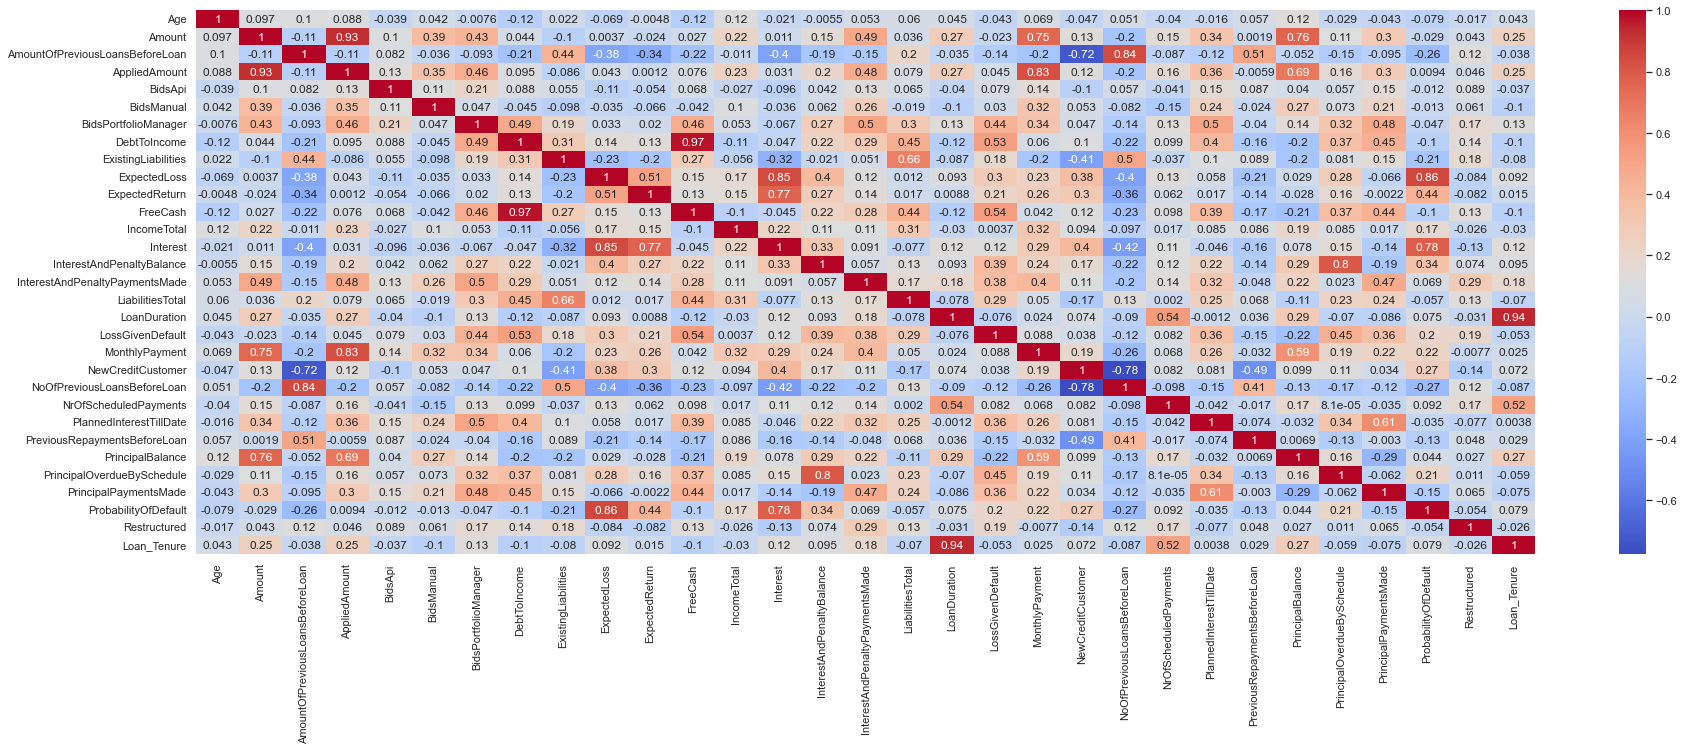

In [31]:
# show the correlation matrix as a heat map
sns.set(rc = {'figure.figsize':(30,10)})
corr = new_data.corr()
sns.heatmap(corr, annot=True,cmap= 'coolwarm')

In [32]:
# get correlated features that have correlation value more than a specific threshold (80%)
def get_correlated_features(threshold): 
    mat=[]
    for i in range(corr.shape[0]):
        
        correltated_features = [] 
        correltated_features.append(corr.columns[i])
        
        for j in range(i):
            if (abs(corr.iloc[i, j]) >= threshold and abs(corr.iloc[i, j]) < 1):
                correltated_features.append(corr.columns[j])
                
        if(len(correltated_features) > 1):
            mat.append(correltated_features)
    return mat

print(get_correlated_features(0.8))

[['AppliedAmount', 'Amount'], ['FreeCash', 'DebtToIncome'], ['Interest', 'ExpectedLoss'], ['MonthlyPayment', 'AppliedAmount'], ['NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan'], ['PrincipalOverdueBySchedule', 'InterestAndPenaltyBalance'], ['ProbabilityOfDefault', 'ExpectedLoss'], ['Loan_Tenure', 'LoanDuration']]


In [33]:
# leave one feature from each correlated features lists and drop the rest
dropped_features=['Amount','FreeCash','ExpectedLoss','MonthlyPayment','AmountOfPreviousLoansBeforeLoan','PrincipalOverdueBySchedule','LoanDuration']
new_data = new_data.drop(dropped_features, axis=1)

In [34]:
# get numerical features
numerical_columns = []
for column in new_data:
    if(new_data[column].dtype == 'float64' or new_data[column].dtype == 'int64'):
        numerical_columns.append(column)

# get categorical features
categorical_columns = []
for column in new_data:
    if(new_data[column].dtype == 'object'):
        categorical_columns.append(column)  
        
# get boolean features
boolean_columns = []
for column in new_data:
    if(new_data[column].dtype == 'bool'):
        boolean_columns.append(column) 

# Feature Engineering

In [35]:
target_mean = targets.groupby('ELA')['EMI'].mean()
targets['ELA'] = targets['ELA'].map(target_mean)

# Encoding Categorical Variables

In [36]:
new_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134529 entries, 0 to 134528
Data columns (total 36 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Age                                134529 non-null  float64
 1   AppliedAmount                      134529 non-null  float64
 2   BidsApi                            134529 non-null  float64
 3   BidsManual                         134529 non-null  float64
 4   BidsPortfolioManager               134529 non-null  float64
 5   Country                            134529 non-null  object 
 6   DebtToIncome                       134529 non-null  float64
 7   Education                          134529 non-null  object 
 8   EmploymentDurationCurrentEmployer  134529 non-null  object 
 9   EmploymentStatus                   134529 non-null  object 
 10  ExistingLiabilities                134529 non-null  float64
 11  ExpectedReturn                     1345

In [37]:

categorical_columns = []
for column in new_data:
    if(new_data[column].dtype == 'object'):
        categorical_columns.append(column)
        
print(categorical_columns)

['Country', 'Education', 'EmploymentDurationCurrentEmployer', 'EmploymentStatus', 'Gender', 'HomeOwnershipType', 'LanguageCode', 'MaritalStatus', 'OccupationArea', 'Rating', 'UseOfLoan', 'VerificationType']


In [38]:
label_mapping={}
le = LabelEncoder()

for column in categorical_columns:   
    
        print(column)
    
        print(new_data[column].unique())
        encoded_values = le.fit_transform(new_data[column])
        
        print(np.unique(encoded_values))
        print('---------------------------------------')
        unique_values = new_data[column].unique()
        label_mapping = dict(zip(unique_values, encoded_values))
        

Country
['EE' 'FI' 'ES' 'SK']
[0 1 2 3]
---------------------------------------
Education
['Vocational education' 'Higher education' 'Secondary education'
 'Basic education' 'Primary education' 'Unknown']
[0 1 2 3 4 5]
---------------------------------------
EmploymentDurationCurrentEmployer
['UpTo3Years' 'MoreThan5Years' 'UpTo4Years' 'UpTo2Years' 'UpTo1Year'
 'Other' 'UpTo5Years' 'TrialPeriod' 'Retiree']
[0 1 2 3 4 5 6 7 8]
---------------------------------------
EmploymentStatus
['Fully employed' 'Unknown' 'Partially employed' 'Self-employed'
 'Entrepreneur' 'Retiree']
[0 1 2 3 4 5]
---------------------------------------
Gender
['Female' 'Male' 'Undefined']
[0 1 2]
---------------------------------------
HomeOwnershipType
['Unknown' 'Homeless' 'Tenant, unfurnished property' 'Living with parents'
 'Owner' 'Tenant, pre-furnished property' 'Council house' 'Mortgage'
 'Joint tenant' 'Joint ownership' 'Owner with encumbrance' 'Other']
[ 0  1  2  3  4  5  6  7  8  9 10 11]
---------------

# Scaling

In [39]:
targets['EMI'] = targets['EMI'].replace([np.inf, -np.inf], np.nan).fillna(0)
targets['ELA'] = targets['ELA'].replace([np.inf, -np.inf], np.nan).fillna(0)
targets['ROI'] = targets['ROI'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [40]:
scaler = StandardScaler()

targets_status = targets['Status']
targets = targets.drop('Status', axis=1)
targets_scaled = pd.DataFrame(scaler.fit_transform(targets), columns = targets.columns)

# Feature Selection

In [41]:
# mutual information for feature selection in regression
mutual_info_emi = mutual_info_regression(new_data, targets_scaled['EMI'])
mutual_info_ela = mutual_info_regression(new_data, targets_scaled['ELA'])
mutual_info_roi = mutual_info_regression(new_data, targets_scaled['ROI'])
mutual_info_status = mutual_info_classif(new_data, targets_status)

ValueError: could not convert string to float: 'EE'

In [ ]:
selected_features_emi = new_data.columns[(-mutual_info_emi).argsort()[:20]]
selected_features_ela = new_data.columns[(-mutual_info_ela).argsort()[:20]]
selected_features_roi = new_data.columns[(-mutual_info_roi).argsort()[:20]]
selected_features_status = new_data.columns[(-mutual_info_status).argsort()[:20]]

In [ ]:
selected_features_emi,selected_features_ela,selected_features_roi,selected_features_status

In [ ]:
combined_array = np.concatenate((selected_features_emi,selected_features_ela,selected_features_roi))
unique_array = np.unique(combined_array)
print(unique_array)
print(len(unique_array))

In [ ]:
new_data_reg = new_data[unique_array]

In [ ]:
new_data_reg.info(verbose = True)

In [ ]:
new_data_class = new_data[selected_features_status]

In [ ]:
new_data_class.info(verbose = True)

In [ ]:
all_features = np.concatenate((unique_array,selected_features_status))
unique_features = np.unique(all_features)
print(unique_features)
print(len(unique_features))

# Modeling

## - Regression 

In [ ]:
# divide the dataset as train set (80%) and validation set (20%)
X_train, X_test, y_train, y_test = train_test_split(new_data_reg, targets_scaled, test_size=0.2, random_state=48)

In [ ]:
linear_regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components =  20)),
    ('classifier', LinearRegression())
])

linear_regression_pipeline.fit(X_train, y_train)
y_pred = linear_regression_pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred, multioutput='raw_values')
print("R2 Score:", r2)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

In [ ]:
ridge_regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components =  20)),
    ('classifier', Ridge())
])

ridge_regression_pipeline.fit(X_train, y_train)
y_pred = ridge_regression_pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred, multioutput='raw_values')
print("R2 Score:", r2)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

In [ ]:
randomforest_regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components =  20)),
    ('classifier', RandomForestRegressor())
])

randomforest_regression_pipeline.fit(X_train, y_train)
y_pred = randomforest_regression_pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred, multioutput='raw_values')
print("R2 Score:", r2)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

In [ ]:
xgb_regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components =  20)),
    ('classifier', XGBRegressor())
])

xgb_regression_pipeline.fit(X_train, y_train)
y_pred = xgb_regression_pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred, multioutput='raw_values')
print("R2 Score:", r2) 

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

## - Classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_data_class, targets_status, test_size=0.2, random_state=48)

In [ ]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components= 10)),
    ('classifier', KNeighborsClassifier())
])
knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ",accuracy)

In [ ]:
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', XGBClassifier())
])
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ",accuracy)

In [ ]:
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', LogisticRegression())
])
logistic_pipeline.fit(X_train, y_train)
y_pred = logistic_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ",accuracy)

In [ ]:
randomforest_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', RandomForestClassifier())
])
randomforest_pipeline.fit(X_train, y_train)
y_pred = randomforest_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ",accuracy)

## - Save models

In [ ]:
# regression 
pickle.dump(linear_regression_pipeline, open('./models/linear_reg.pkl', 'wb'))
pickle.dump(ridge_regression_pipeline, open('./models/ridge_reg.pkl', 'wb'))
pickle.dump(randomforest_regression_pipeline, open('./models/randomforest_reg.pkl', 'wb'))
pickle.dump(xgb_regression_pipeline, open('./models/xgb_reg.pkl', 'wb'))

# classification
pickle.dump(knn_pipeline, open('./models/knn_classif.pkl', 'wb'))
pickle.dump(xgb_pipeline, open('./models/xgb_classif.pkl', 'wb'))
pickle.dump(logistic_pipeline, open('./models/logistic_classif.pkl', 'wb'))
pickle.dump(randomforest_pipeline, open('./models/randomforest_classif.pkl', 'wb'))